In [125]:
import os
import sys
import pathlib
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from scipy.io.wavfile import read
import wave
from sklearn.model_selection import train_test_split
import librosa
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
import sounddevice as sd
from scipy.io.wavfile import write
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import  Conv1D, GRU, Dropout, Input, Dense, Conv2D, Reshape, MaxPooling2D
import random
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from scipy import linalg
from pydub import AudioSegment
random.seed(111)
sample_rate = 16000

#D:\Koulujutut\audio_project\training_data\car
#path = pathlib.Path().resolve()
#str(path.parents[0])}

car_train_data_path = f"../Project/audio_project_data/training_data/car/"
tram_train_data_path = f"../Project/audio_project_data/training_data/tram/"

car_val_data_path = f"../Project/audio_project_data/validation_data/car/"
tram_val_data_path = f"../Project/audio_project_data/validation_data/tram/"
 

In [126]:
for file in os.listdir(car_train_data_path):
        if file.endswith(".mp3"):
            print(os.path.join(car_train_data_path, file))
            audio = AudioSegment.from_mp3(os.path.join(car_train_data_path, file))
            wav_file = file.replace("mp3", "")
            audio.export(os.path.join(car_train_data_path, wav_file), format="wav")

for file in os.listdir(tram_train_data_path):
    if file.endswith(".mp3"):
        audio = AudioSegment.from_mp3(os.path.join(tram_train_data_path, file))
        wav_file = file.replace("mp3", "")
        audio.export(os.path.join(tram_train_data_path, wav_file), format="wav")

for file in os.listdir(car_val_data_path):
    if file.endswith(".mp3"):
        audio = AudioSegment.from_mp3(os.path.join(car_val_data_path, file))
        wav_file = file.replace("mp3", "")
        audio.export(os.path.join(car_val_data_path, wav_file), format="wav")

for file in os.listdir(tram_val_data_path):
    if file.endswith(".mp3"):
        audio = AudioSegment.from_mp3(os.path.join(tram_val_data_path, file))
        wav_file = file.replace("mp3", "")
        audio.export(os.path.join(tram_val_data_path, wav_file), format="wav")


In [127]:
def spec_augment(spec: np.ndarray, num_mask=2, 
                 freq_masking_max_percentage=0.10, time_masking_max_percentage=0.10):

    spec = spec.copy()
    for i in range(num_mask):
        all_frames_num, all_freqs_num = spec.shape
        freq_percentage = random.uniform(0.0, freq_masking_max_percentage)
        
        num_freqs_to_mask = int(freq_percentage * all_freqs_num)
        f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
        f0 = int(f0)
        spec[:, f0:f0 + num_freqs_to_mask] = 0

        time_percentage = random.uniform(0.0, time_masking_max_percentage)
        
        num_frames_to_mask = int(time_percentage * all_frames_num)
        t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
        t0 = int(t0)
        spec[t0:t0 + num_frames_to_mask, :] = 0
    
    return spec


In [128]:
car_train_data = []
tram_train_data = []
car_test_data = []
tram_test_data = []
car_val_data = []
tram_val_data = []
sample_rate = 16000
car_train_data_aug = []
tram_train_data_aug = []
car_audio = []
tram_audio = []
#The lenght of longest audio sample is defined here.
# For every audio sample zeros are added to make samples to be 
# in same size.
longest_sample = 125611



#audio = np.hstack((audio, np.zeros(longest_sample - len(audio))))
for car in os.listdir(car_train_data_path):
    
    audio, fs = librosa.load(os.path.join(car_train_data_path, car), sr=16000)
    # if len(audio) > longest_sample:
    #     longest_sample = len(audio)
    audio = np.hstack((audio, np.zeros(longest_sample - len(audio))))
    car_audio.append(audio)
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=512, hop_length=160, n_mels=48, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).T
    mel_spec_db_norm = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db))
    car_train_data.append(mel_spec_db_norm.T) 
    

    mel_spec_db = librosa.power_to_db(spec_augment(mel_spec), ref=np.max).T
    mel_spec_db_norm = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db))
    car_train_data_aug.append(mel_spec_db_norm.T) 



    
for car in os.listdir(car_val_data_path):
    audio, fs = librosa.load(os.path.join(car_val_data_path, car), sr=16000)
    
    #if len(audio) > longest_sample:
    #    longest_sample = len(audio)
    audio = np.hstack((audio, np.zeros(longest_sample - len(audio))))

    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=512, hop_length=160, n_mels=48, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).T
    mel_spec_db_norm = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db))
    car_val_data.append(mel_spec_db_norm.T) 
    
    
    

for tram in os.listdir(tram_train_data_path):
    audio, fs = librosa.load(os.path.join(tram_train_data_path, tram), sr=16000)    
    
    # if len(audio) > longest_sample:
    #     longest_sample = len(audio)
    audio = np.hstack((audio, np.zeros(longest_sample - len(audio))))
        
    tram_audio.append(audio)
    
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=512, hop_length=160, n_mels=48, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).T
    mel_spec_db_norm = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db))
    tram_train_data.append(mel_spec_db_norm.T)

    
    mel_spec_db = librosa.power_to_db(spec_augment(mel_spec), ref=np.max).T
    mel_spec_db_norm = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db))
    tram_train_data_aug.append(mel_spec_db_norm.T) 
    

    
for tram in os.listdir(tram_val_data_path):
    
    audio, fs = librosa.load(os.path.join(tram_val_data_path, tram), sr=16000)
    
    # if len(audio) > longest_sample:
    #    longest_sample = len(audio)
    audio = np.hstack((audio, np.zeros(longest_sample - len(audio))))

    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=512, hop_length=160, n_mels=48, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).T
    mel_spec_db_norm = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db))
    tram_val_data.append(mel_spec_db_norm.T)

     




In [129]:
def time_shift(audio): 
    return np.roll(audio,int(16000/(random.randint(2,10)))) 



for audio_first in car_audio:
        audio_shifted = time_shift(audio_first)*random.uniform(0.6, 0.9)
        mel_spec = librosa.feature.melspectrogram(y=audio_shifted, sr=sample_rate, n_fft=512, hop_length=160, n_mels=48, fmax=8000)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).T
        mel_spec_db_norm = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db))
        car_train_data.append(mel_spec_db_norm.T) 
    

for audio_first in tram_audio:
        audio_shifted = time_shift(audio_first)*random.uniform(0.6, 0.9)
        mel_spec = librosa.feature.melspectrogram(y=audio_shifted, sr=sample_rate, n_fft=512, hop_length=160, n_mels=48, fmax=8000)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).T
        mel_spec_db_norm = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db))
        tram_train_data.append(mel_spec_db_norm.T)
        

car_train_data = car_train_data + car_train_data_aug
tram_train_data = tram_train_data + tram_train_data_aug

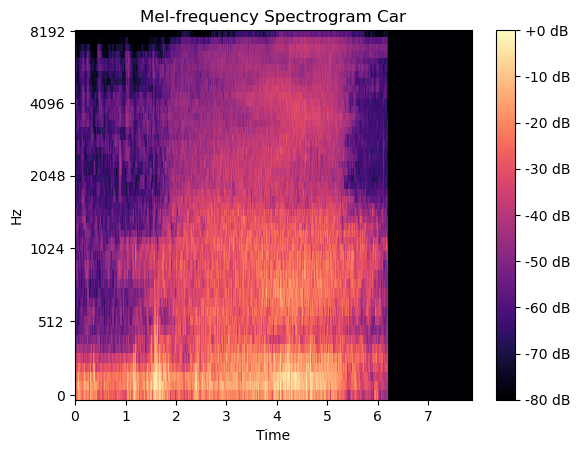

In [130]:
import librosa.display
y = car_audio[10]
mel_spec = librosa.feature.melspectrogram(y=y, sr=sample_rate, n_fft=512, hop_length=160, n_mels=48, fmax=8000)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).T
fig, ax = plt.subplots()
img = librosa.display.specshow(mel_spec_db.T,sr=16000, x_axis='time',n_fft=512,hop_length=160,
y_axis='mel', fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency Spectrogram Car')
plt.savefig('mel_spec_car.png')


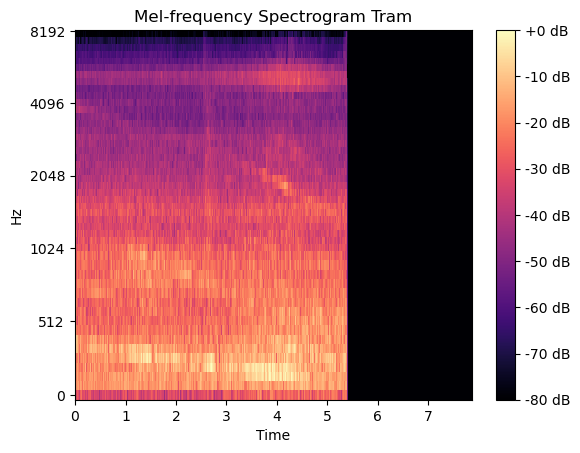

In [131]:
import librosa.display
y = tram_audio[5]
mel_spec = librosa.feature.melspectrogram(y=y, sr=sample_rate, n_fft=512, hop_length=160, n_mels=48, fmax=8000)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).T
fig, ax = plt.subplots()
img = librosa.display.specshow(mel_spec_db.T,sr=16000, x_axis='time',n_fft=512,hop_length=160,
y_axis='mel', fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency Spectrogram Tram')
plt.savefig('mel_spec_tram.png')

In [132]:
print(np.shape(car_train_data))
print(np.shape(tram_train_data))
print(np.shape(car_val_data))
print(np.shape(tram_val_data))

car_train_data = np.squeeze(car_train_data)
tram_train_data = np.squeeze(tram_train_data)
car_val_data = np.squeeze(car_val_data)
tram_val_data = np.squeeze(tram_val_data)

keyword_labels = np.ones(car_train_data.shape[0])
val_pos_labels = np.ones(car_val_data.shape[0])

noise_labels = 0*np.ones(tram_train_data.shape[0])
val_neg_labels = 0*np.ones(tram_val_data.shape[0])

X_train = np.concatenate((car_train_data, tram_train_data), axis=0)
y_train  = np.concatenate((keyword_labels, noise_labels), axis=0)

X_val = np.concatenate((car_val_data, tram_val_data), axis=0)
y_val = np.concatenate((val_pos_labels, val_neg_labels), axis=0)

y_train = tf.keras.utils.to_categorical(y_train, 2)
y_val = tf.keras.utils.to_categorical(y_val, 2)

(780, 48, 786)
(600, 48, 786)
(41, 48, 786)
(20, 48, 786)


In [133]:
from keras.backend import manual_variable_initialization 
manual_variable_initialization(True)

num_units = 48
dropout_ratio = 0.3
checkpoint_filepath = f'../Project/vehicle_model_1D_CRNN'
checkpoint_dir = os.path.dirname(checkpoint_filepath)

my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=120, mode='min'),
                tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, 
                monitor='val_accuracy', mode='max', save_best_only=True),
]

model = Sequential([
    Input(shape=(car_train_data.shape[1], car_train_data.shape[2])),
    Conv1D(num_units,3,padding="same",activation='relu',name='layer1'),
    Dropout(dropout_ratio),
    Conv1D(num_units,3,padding="same",activation='relu',name='layer2'),
    Dropout(dropout_ratio),
    GRU(num_units,name='RNN_1',return_sequences=False),
    Dense(2, activation='softmax', name='dense_a'),
])

model.compile(loss='BinaryCrossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Conv1D)             (None, 48, 48)            113232    
                                                                 
 dropout_4 (Dropout)         (None, 48, 48)            0         
                                                                 
 layer2 (Conv1D)             (None, 48, 48)            6960      
                                                                 
 dropout_5 (Dropout)         (None, 48, 48)            0         
                                                                 
 RNN_1 (GRU)                 (None, 48)                14112     
                                                                 
 dense_a (Dense)             (None, 2)                 98        
                                                                 
Total params: 134,402
Trainable params: 134,402
Non-tr

In [134]:
history = model.fit(X_train, y_train, epochs=1000, batch_size=4, callbacks=my_callbacks, 
                    validation_data=(X_val, y_val))


Epoch 1/1000
339/345 [============================>.] - ETA: 0s - loss: 0.6576 - accuracy: 0.5701

INFO:tensorflow:Assets written to: ../Project/vehicle_model_1D_CRNN/assets


INFO:tensorflow:Assets written to: ../Project/vehicle_model_1D_CRNN/assets


345/345 [==============================] - 4s 9ms/step - loss: 0.6565 - accuracy: 0.5717 - val_loss: 0.5143 - val_accuracy: 0.8525
Epoch 2/1000
345/345 [==============================] - 2s 5ms/step - loss: 0.6199 - accuracy: 0.6449 - val_loss: 0.5161 - val_accuracy: 0.7541
Epoch 3/1000
345/345 [==============================] - 2s 5ms/step - loss: 0.5878 - accuracy: 0.6855 - val_loss: 0.4509 - val_accuracy: 0.7705
Epoch 4/1000
345/345 [==============================] - 2s 5ms/step - loss: 0.5611 - accuracy: 0.7065 - val_loss: 0.4827 - val_accuracy: 0.7541
Epoch 5/1000
345/345 [==============================] - 2s 6ms/step - loss: 0.5498 - accuracy: 0.7116 - val_loss: 0.4962 - val_accuracy: 0.7377
Epoch 6/1000
345/345 [==============================] - 2s 5ms/step - loss: 0.5293 - accuracy: 0.7268 - val_loss: 0.4936 - val_accuracy: 0.7049
Epoch 7/1000
345/345 [==============================] - 2s 5ms/step - loss: 0.5135 - accuracy: 0.7457 - val_loss: 0.5663 - val_accuracy: 0.7049
Epoch

INFO:tensorflow:Assets written to: ../Project/vehicle_model_1D_CRNN/assets


INFO:tensorflow:Assets written to: ../Project/vehicle_model_1D_CRNN/assets


345/345 [==============================] - 3s 10ms/step - loss: 0.3209 - accuracy: 0.8688 - val_loss: 0.3148 - val_accuracy: 0.8689
Epoch 14/1000
345/345 [==============================] - 2s 5ms/step - loss: 0.2935 - accuracy: 0.8855 - val_loss: 0.2999 - val_accuracy: 0.8689
Epoch 15/1000
340/345 [============================>.] - ETA: 0s - loss: 0.2652 - accuracy: 0.9059

INFO:tensorflow:Assets written to: ../Project/vehicle_model_1D_CRNN/assets


INFO:tensorflow:Assets written to: ../Project/vehicle_model_1D_CRNN/assets


345/345 [==============================] - 3s 9ms/step - loss: 0.2657 - accuracy: 0.9058 - val_loss: 0.2700 - val_accuracy: 0.9344
Epoch 16/1000
345/345 [==============================] - 2s 5ms/step - loss: 0.2409 - accuracy: 0.9181 - val_loss: 0.2730 - val_accuracy: 0.9344
Epoch 17/1000
345/345 [==============================] - 2s 5ms/step - loss: 0.2277 - accuracy: 0.9232 - val_loss: 0.2843 - val_accuracy: 0.9344
Epoch 18/1000
345/345 [==============================] - 2s 5ms/step - loss: 0.2247 - accuracy: 0.9196 - val_loss: 0.2807 - val_accuracy: 0.9344
Epoch 19/1000
345/345 [==============================] - 2s 5ms/step - loss: 0.2123 - accuracy: 0.9239 - val_loss: 0.3066 - val_accuracy: 0.9180
Epoch 20/1000
345/345 [==============================] - 2s 5ms/step - loss: 0.2011 - accuracy: 0.9261 - val_loss: 0.2898 - val_accuracy: 0.9180
Epoch 21/1000
345/345 [==============================] - 2s 5ms/step - loss: 0.1928 - accuracy: 0.9377 - val_loss: 0.2772 - val_accuracy: 0.9344

In [ ]:
#checkpoint_dir = os.path.dirname(checkpoint_filepath)
#latest = tf.train.latest_checkpoint(checkpoint_dir)
model = tf.keras.Model()
#model.load_model(latest)
model=tf.keras.models.load_model('../Project/vehicle_model_1D_CRNN')

model.evaluate(X_val, y_val, batch_size=4)

16/16 [==============================] - 0s 2ms/step - loss: 0.4222 - accuracy: 0.9016


[0.42221197485923767, 0.9016393423080444]

In [ ]:
car_test_data_path = f"../Project/audio_project_data/test_data/car/"
tram_test_data_path = f"../Project/audio_project_data/test_data/tram/"
car_test_data = []
tram_test_data = []

for file in os.listdir(car_test_data_path):
    if file.endswith(".mp3"):
        audio = AudioSegment.from_mp3(os.path.join(car_test_data_path, file))
        wav_file = file.replace(".mp3", "")
        audio.export(os.path.join(car_test_data_path, wav_file), format="wav")

for file in os.listdir(tram_test_data_path):
    if file.endswith(".mp3"):
        audio = AudioSegment.from_mp3(os.path.join(tram_test_data_path, file))
        wav_file = file.replace(".mp3", "")
        audio.export(os.path.join(tram_test_data_path, wav_file), format="wav")

for file in os.listdir(car_test_data_path):
    audio, fs = librosa.load(os.path.join(car_test_data_path, file), sr=16000)
    #if len(audio) > longest_sample:
    #    longest_sample = len(audio)
    audio = np.hstack((audio, np.zeros(longest_sample - len(audio))))
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=512, hop_length=160, n_mels=48, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).T
    mel_spec_db_norm = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db))
    car_test_data.append(mel_spec_db_norm.T) 


for file in os.listdir(tram_test_data_path):
    audio, fs = librosa.load(os.path.join(tram_test_data_path, file), sr=16000)
    #if len(audio) > longest_sample:
    #    longest_sample = len(audio)
    audio = np.hstack((audio, np.zeros(longest_sample - len(audio))))
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=512, hop_length=160, n_mels=48, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).T
    mel_spec_db_norm = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db))
    tram_test_data.append(mel_spec_db_norm.T) 

#print(longest_sample)

In [ ]:
print(np.shape(car_test_data))
print(np.shape(tram_test_data))
car_test_data = np.squeeze(car_test_data)
tram_test_data = np.squeeze(tram_test_data)
test_pos_labels = np.ones(car_test_data.shape[0])
test_neg_labels = 0*np.ones(tram_test_data.shape[0])

X_test = np.concatenate((car_test_data, tram_test_data), axis=0)
y_test = np.concatenate((test_pos_labels, test_neg_labels), axis=0)
y_test = tf.keras.utils.to_categorical(y_test, 2)

(50, 48, 786)
(41, 48, 786)


In [ ]:

model.evaluate(X_test, y_test, batch_size=4)
hypothesis= model.predict(X_test, batch_size=4)
y_pred = tf.keras.utils.to_categorical(hypothesis, 2)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

y_true = y_test[:, 1]
#fpr, tpr, thresholds = precision_recall_curve(y_true, y_pred)

y_pred = np.round(hypothesis[:, 1])
CM = confusion_matrix(y_true, y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
Precision = TP/(TP+FP)
Recall = TP/(TP+FN)
F1_score = 2*((Precision*Recall)/(Precision+Recall))
print(f"true negatives: {TN}, false negatives: {FN}, true positives {TP}, false positives {FP}")
print(f" Precision: {Precision}")
print(f" Recall: {Recall}")
print(f" F1 score: {F1_score}")

23/23 [==============================] - 0s 2ms/step
true negatives: 25, false negatives: 1, true positives 49, false positives 16
 Precision: 0.7538461538461538
 Recall: 0.98
 F1 score: 0.8521739130434782
